# Cell Phone Records
The goal is to study a social network dataset (CellPhoneCallRecords.csv) that was released in part by the U.S. government. It consists of 400 unique cell phone identifications over a ten day period. Altogether, there are 9834 phone records with the following fields:  

* Calling phone identifier
* Receiving phone identifier 
* Date
* Time of day 
* Call duration 
* Cell tower closest to the call origin

The goal is to characterize the social structure over time for a **controversial sociopolitical movement**. 


In [1]:
import pandas as pd

records = pd.read_csv('./CellPhoneCallRecords.csv')
records = records.set_index(records.columns[0])

records[:5]

,From,To,DateTime,Duration.seconds.,Cell.Tower
Unnamed: 0,,,,,
1,349,23,6/1/2006 0:08,1634,1
2,379,364,6/1/2006 0:11,640,24
3,392,27,6/1/2006 0:12,1182,29
4,17,339,6/1/2006 0:14,578,23
5,272,251,6/1/2006 0:15,887,29


# Quick Data Summaries

* Who are the nodes that call the most? 
* And what is their average call duration?
* How does this compare to the average number of calls and duration overall?

In [2]:
# Group by the caller ID and aggregate the number of calls 
high_callers = records.groupby('From').count()['To'].sort_values(ascending=False)[:10]
high_caller_records = records[records['From'].isin(list(high_callers.keys()))]
duration = high_caller_records.groupby('From').mean()['Duration.seconds.']

high_callers_table = pd.concat([high_callers, duration], axis=1)
high_callers_table.columns = ['Number of Calls', 'Average Duration']

calls_per_person = records.groupby('From').count()['To']
mean_calls = str(calls_per_person.mean())
median_calls = str(calls_per_person.median())
mean_duration = str(records.mean()['Duration.seconds.'])
median_duration = str(records.median()['Duration.seconds.'])

print("For comparison,\n")
print("    number of calls:\n         mean - " + mean_calls + "; median - " + median_calls)
print("")
print("    the average duration of calls:\n         mean - " + mean_duration + "; median - " + median_duration)

high_callers_table

For comparison,

    number of calls:
         mean - 24.585; median - 25.0

    the average duration of calls:
         mean - 1065.25096604; median - 1064.5


,Number of Calls,Average Duration
From,,
58,38,1069.868421
59,36,1091.333333
66,38,1122.026316
104,36,1102.722222
118,37,1079.270270
176,36,1039.222222
228,38,1120.368421
230,38,1040.578947
259,36,1008.888889


# In vs. Out Degree

Identify, for each node, the number of links into and out of the node. This is often used as a node's degree of influence within their immediate "neighborhood"


In [3]:
from bokeh.charts import Scatter, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool

output_notebook()

outbound = records.groupby('From').count()['To']
inbound = records.groupby('To').count()['From']
node_flow = pd.concat([outbound, inbound], axis=1)

hover = HoverTool(tooltips="""
<span style="font-size: 17px; font-weight: bold;">Node: $index</span>""")
p = Scatter( node_flow, x='From',y='To', title="Inbound vs. Outbound Calls", 
            tools=[hover], plot_width=900)

show(p)

Loading BokehJS ...

It looks like three nodes of special interest can be identified from this plot: **0, 1, and 5**

# Network Analysis and Plotting

We can identify 3 nodes, but should look to see two more... Let's find this by using NetworkX, a graph library in Python. We were told that Node #200 is a node of special interest, so let's construct the network graph and then the ego graph of node 200.

An "Ego" is an individual "focal" node. We can draw the network around it.

For our graph construction
* Nodes = Callers
* Edges = Every call
* Edge Weight = Call Duration

In [4]:
import networkx as nx

# Initialize Graph
G = nx.Graph()

# Get list of possible nodes
node_from = records['From'].unique()
node_to = records['To'].unique()

nodes = list(set().union(node_from,node_to))
G.add_nodes_from(nodes)

# Add From and To Edges
for i, record in records.iterrows():
    G.add_edge(record['From'],record['To'], weight=record['Duration.seconds.'])

## Betweenness Centrality
Betweenness Centrality is a measure of centrality, where the higher a node's "Betweenness Centrality", the more communication passes through that node. Therefore, the higher the Betweenness Centrality, the higher the node's control over the network.

In our graph, we will use this as the node radius so we can easily identify the most central nodes.

## Community Partitions
Are there separate communities in our graph? The best way to visualize this is to use the louvain method of community detection. We choose node colors based on their community

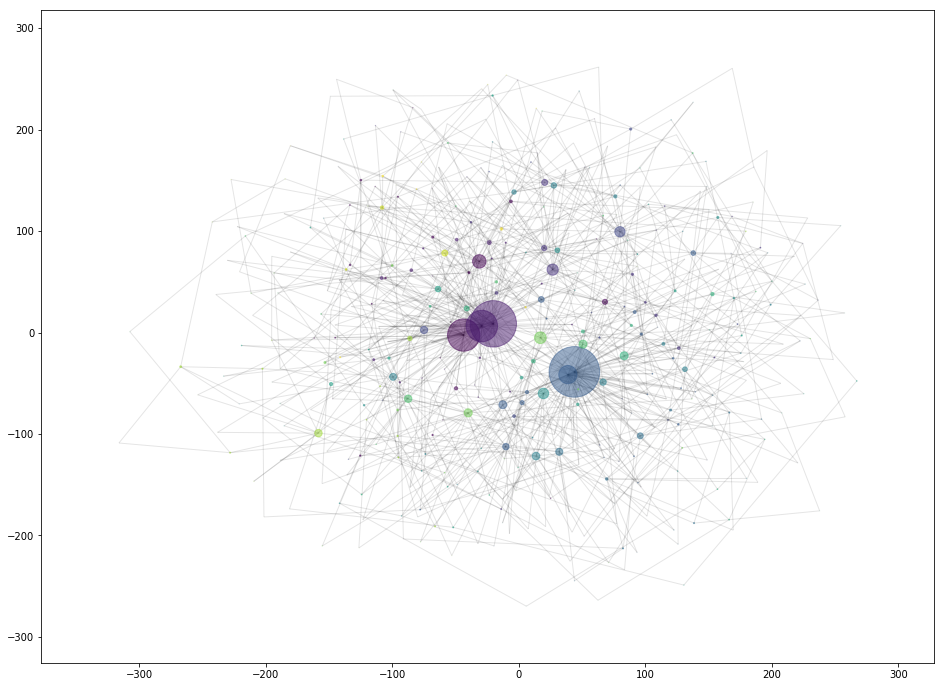

In [5]:
from networkx.drawing.nx_agraph import graphviz_layout
import community

%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(16, 12))

pos = graphviz_layout(G)
bt = nx.betweenness_centrality_source(G, normalized=True, weight='weight', sources=nodes)
parts = community.best_partition(G)

node_sizes = [ 50000*x*x for x in list(bt.values())]
community_colors = list(parts.values())

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=community_colors, alpha=0.5)
nx.draw_networkx_edges(G, pos, alpha=0.1, style='solid')


In [6]:
import operator

sorted_x = sorted(bt.items(), key=operator.itemgetter(1), reverse=True)

print("The Top Nodes are: " + ' '.join([str(x[0]) for x in sorted_x[:5]]))

The Top Nodes are: 5 1 0 309 306



We've learned a couple things from our plotting:
* There isn't a very strong segmentation in this network. Communities are sprinkled here and there.
* Our strongest influencers are nodes: 5, 1, 0, 309, 306
* It is clear that the network revolves around a few central nodes

But Node 200 hasn't shown up. So why is it important? 

{1: <matplotlib.text.Text at 0x7f3ecd277cf8>,
 2: <matplotlib.text.Text at 0x7f3ecd27e278>,
 3: <matplotlib.text.Text at 0x7f3ecd27e7b8>,
 5: <matplotlib.text.Text at 0x7f3ecd27ecf8>,
 97: <matplotlib.text.Text at 0x7f3ecd203278>,
 137: <matplotlib.text.Text at 0x7f3ecd203cf8>,
 200: <matplotlib.text.Text at 0x7f3ecd2037b8>}

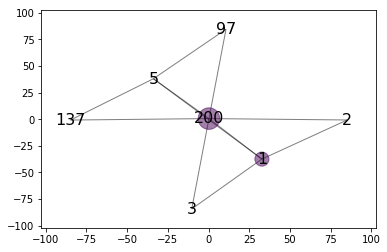

In [10]:
ego = nx.ego_graph(G,200)

pos = graphviz_layout(ego)
bt2 = nx.betweenness_centrality_source(ego, normalized=True, weight='weight', sources=ego.nodes())
parts2 = community.best_partition(ego)

node_sizes = [ 1000*x for x in list(bt2.values())]
community_colors = list(parts2.values())

nx.draw_networkx_nodes(ego, pos, node_size=node_sizes, node_color=community_colors, alpha=0.5)
nx.draw_networkx_edges(ego, pos, alpha=0.5, style='solid')
labels = {node: str(node) for node in ego.nodes()}
nx.draw_networkx_labels(ego,pos,labels,font_size=16)


Aha! Node 200 is actually a bridge node between the two most powerful nodes in our data: 1 and 5.

Given the results above, we should consider what are the leader nodes for each community and possibly who connects them.

In [8]:
# For each community, what's the highest centrality?

overall = { node: {
            'betweenness': bt[node], 
            'community': parts[node] 
            } 
           for node in nodes}
communities = list(set(parts.values()))
node_df = pd.DataFrame.from_dict(overall, orient="index").reset_index()
node_df.sort_values(['betweenness'],ascending=False).groupby('community').first()

,index,betweenness
community,,
0,0,0.144507
1,1,0.207617
2,3,0.050088
3,23,0.046234
4,5,0.226527
5,7,0.031719
6,113,0.034219
7,13,0.047122
8,14,0.024893


# Are there any behavior changes over time?

I have been provided the following prompt:
> You have not-so-reliable intelligence that the leaders of the sociopolitical movement suspected the US of successfully spying on their calls. Can you spot any evidence that the key individuals changed their behavior at some point in time? 

To identify any changes in behavior, let's aggregate at the date and node level:
* Number of outbound calls 
* Number of inbound calls
* Call Duration

With 10 days of information, we can probably calculate the mean and standard deviation, making note of any outliers. We also look at outbound calls instead of inbound because those are more controllable by user behavior. So we can see if there is a meaningful difference between the first 5 and last 5 days per node.

Using a t-statistic of 2.82 for an alpha of 0.005 (99% confidence).

In [59]:
import datetime

def string_to_date(date_string):
    day = date_string.split(' ')[0].split('/')[1]
    return int(day)

records['date'] = records['DateTime'].apply(string_to_date)
outbound_records = records.pivot_table(values='To', index='date', columns='From', aggfunc='count', fill_value=0)
start = outbound_records[:5]
end = outbound_records[6:]

In [73]:
from math import sqrt

def get_t_statistic(obs):
    mean_diff = obs['start_mean'] - obs['end_mean']
    variance_start = (obs['start_std']**2)/len(obs)
    variance_end = (obs['end_std']**2)/len(obs)
    total_variance = sqrt(variance_start + variance_end)
    return abs(mean_diff/total_variance)

summary = pd.DataFrame.from_dict({ 
    a: dict(
        start_mean = start.mean()[a],
        end_mean = end.mean()[a],
        start_std = start.std()[a],
        end_std = end.std()[a],
        start_med = start.median()[a],
        end_med = end.median()[a]
    ) for a in outbound_records
}, orient='index')

summary['t'] = summary.apply(lambda x: get_t_statistic(x), axis=1)
changers = summary[summary['t'] > 2.82].sort_values('t', ascending = False)

Using the difference between starting mean and ending mean, we have been able to find people who changed caller behavior from the beginning

We have 24 people who changed behavior
Here is a plot of a few


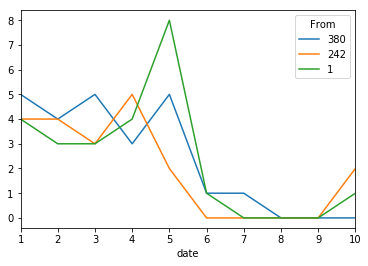

In [82]:
print("We have "+str(len(changers)) + " people who changed behavior")
print("Here is a plot of a few")

outbound_records[[380,242,1]].plot()